TO-DO NEXT:  
* Create a performance test function:
    1. Get ratio of failed identification (for a subset of images).
    2. Get the center values for all fails and use it to redefine template space.
    3. Test new space on a subset.
    
    - Focus should be on the colors defined by ifs and not euclidean distances - black, white, gray. ALTHOUGH white gray seem impossible to resolve. (For now white is not defined.)
    - orange-yellow-red-pink, green-forest, black-brown need to be better resoved.  
    

* Optimize nice to haves - chose k, window size..
* Further optimization - look at the size of euclidean distance when deciding between colors instead of cluster size.
    - This should be also used for confidance 

In this notebook I'm testing climbing hold color identification using a kmean clustering of pixels within each bounding box of holds.  

Source:  
https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71   

https://stackoverflow.com/questions/2453344/find-the-colour-name-from-a-hexadecimal-colour-code/65074672#65074672  
https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python  

how to choose K:  
https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

rgb to color name:  
https://web.njit.edu/~walsh/rgb_nobg/

RGB/hex doesn't make sense to me. Example: (30,30,30)=gray (30,30,35)=blue.  
Thus, HSL or HSV seems like a better guess.    

CV2 has - COLOR_RGB2HSV and COLOR_RGB2HLS (or COLOR_BGR2HXX), and reverse.  
COLOR_RGB2HLS uint8 behaviour - [R,G,B] -> [0<H<180, 0<L<255, 0<S<255].  
so conversion from HLS classic values to function returned values - Hx0.5, Lx2.55, Sx2.55.  
https://docs.opencv.org/3.4.6/de/d25/imgproc_color_conversions.html  
In the future, I might want to set different weights to the different channels, to gain weighted sensitivity of the euclidean distance.

HSV:  
Hue - the dominant color perceived.  
Sauturation - the amount of white light mixed with the hue.  
Value - chromatic notion of intensity. Lower is blacker, higher is more similar to color.  

HSL:  
Hue - the dominant color.   
Saturation - purity of the color - low is grayer.   
Lightness/luminosity - Low black and high white.  

Maybe(?) gray is easier to define in HSL than HSV.  

Even if doing euclidean distance and not range per color, might be better to have two values per color, and if exceptions for black, white, and gray.

RGB TO HSL converter:  
https://www.rapidtables.com/convert/color/rgb-to-hsl.html

In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches 

import cv2
#import colorsys


import numpy as np
from collections import Counter#, OrderedDict
#from skimage.color import rgb2lab, deltaE_cie76
import os
from glob import glob
import pandas as pd
import time

from sklearn.cluster import KMeans

%matplotlib inline

In [2]:
## values to multiply to convert HSL classic values to CV2 uint8 format of HLS (explained above)
hls2cv2hls = [0.5,2.55,2.55]

## give H,L,S weights - e.g. make hue count more when calculating euc dist.
## only applied when calculating euc distance, not for kmeans
hls_weights = [1.4,0.25,0.25]

In [3]:
def RGB2HEX(rgb_color):
    return "{:02x}{:02x}{:02x}".format(int(rgb_color[0]), int(rgb_color[1]), int(rgb_color[2]))

## Define template colors:

In [4]:
##### color numbers were defined/annotated in master thesis work.
##### I linked color to number by running the code below first to view the images and corresponding colors. ####

# construct color info:

## image 0119 has two wrong annotations - 9 should be changed to 12
## I think image 0148 might have two wrong annotations 11 - might be violet or black.
## volumes are annotated as black

## Beta7 colors:
## black, forest, gray, green, red, violet, cornflower, blue, orange, pink, white, yellow
## NAVY, 
## MULTICOLOR - BROWN-BLACK, BLACK-WHITE, VIOLET-WHITE, RAINBOW?

color_dict = {
    0:'black',
    1:'brown',
    '1_1':'brown1',
    2:'forest',
    '2_1':'forest1',
    '2_2':'forest2',
    5:'gray',
    6:'green',
    '6_1':'green1',
    7:'red',
    '7_1':'red1',
    9:'violet',
    '9_1':'violet1',
    10:'cornflower',
    11:'blue', 
    12:'orange',
    14:'pink',
    '14_1':'pink1',
    15:'white', ## Includes dual white violet in image 0149 - those are usually violet routes??
    16:'yellow',
}

In [5]:
## notice that its L then S
## need to think about the circular nature of H (360=0), especially for red-ish hues (pink, red, brown). 
## Done manually - need to refine.

hls_dict = {
    # defined in an if: l<~16
    'black': (0,0,0), ## black is defined by L=0, no matter the HS.
    'brown': (360, 25, 25),
    'brown1': (0, 25, 25),
    'forest': (135,20,25),
    'forest1': (160,20,30),
    'forest2': (135,10,100),
    # defined in an if: s<~12
    'gray': (0,80,0), ## gray is S=0, L will effect the lightness, H has no effect
    'green': (80, 30, 75),
    'green1': (135, 40, 60),
    'red': (360, 30, 40), ## 0=360!! need to correct in the future.
    'red1': (0, 30, 40),
    'violet': (280, 50, 65),
    'violet1': (320, 40, 30),
    'cornflower': (180, 40, 40),
    'blue': (210, 40, 60), 
    'orange': (10, 60, 80),
    'pink': (345, 50, 50),
    'pink1': (0, 80, 70),
    'white': (0, 100, 0), ## white is defined by L=100, no matter the HS.
    'yellow': (40, 40, 60),
}

In [6]:
# template color dataframe - will build up in the future..
df_template_color = pd.DataFrame(color_dict.items(), columns=["index","name"])
df_template_color['hls'] = df_template_color["name"].map(hls_dict)

In [7]:
# add formated cv2 hls colors: 
df_template_color["hls_cv2"] = df_template_color["hls"].apply(lambda x: 
                                                              (int(x[0]*hls2cv2hls[0]),
                                                               int(x[1]*hls2cv2hls[1]),
                                                               int(x[2]*hls2cv2hls[2])))

# add rgb values:
df_template_color["rgb"] = [cv2.cvtColor(((np.asarray(c)).astype(np.uint8).reshape([1,1,3])), cv2.COLOR_HLS2RGB)[0][0] 
                            for c in df_template_color["hls_cv2"]]

# add hex values:
df_template_color["hex"] = [RGB2HEX(c) for c in df_template_color["rgb"]]

In [8]:
df_template_color

,index,name,hls,hls_cv2,rgb,hex
0,0,black,"(0, 0, 0)","(0, 0, 0)","[0, 0, 0]",000000
1,1,brown,"(360, 25, 25)","(180, 63, 63)","[79, 47, 47]",4f2f2f
2,1_1,brown1,"(0, 25, 25)","(0, 63, 63)","[79, 47, 47]",4f2f2f
3,2,forest,"(135, 20, 25)","(67, 51, 63)","[38, 64, 44]",26402c
4,2_1,forest1,"(160, 20, 30)","(80, 51, 76)","[36, 66, 56]",244238
5,2_2,forest2,"(135, 10, 100)","(67, 25, 254)","[0, 50, 12]",00320c
6,5,gray,"(0, 80, 0)","(0, 204, 0)","[204, 204, 204]",cccccc
7,6,green,"(80, 30, 75)","(40, 76, 191)","[95, 133, 19]",5f8513
8,6_1,green1,"(135, 40, 60)","(67, 102, 153)","[41, 163, 69]",29a345
9,7,red,"(360, 30, 40)","(180, 76, 102)","[106, 46, 46]",6a2e2e


In [9]:
## create color matrix from the template colors.
## will be used to compare euclidean distance to detected color of hold.
## format: [[color1_H,color1_L,color1_S],[color2_H,color2_L,color2_S],...]
hls_mat_for_euc = np.asarray(df_template_color.hls_cv2.tolist())#, dtype=np.uint16)
hls_mat_for_euc.shape

(20, 3)

In [10]:
## convert template values:
hls_mat_for_euc = (hls_mat_for_euc*hls_weights).astype(np.uint8)

In [11]:
## viewing max for each channel to estimate the weights
np.max(hls_mat_for_euc, axis=0)

array([251,  63,  63], dtype=uint8)

In [12]:
%%timeit
## test time of comparing a color's euclidean distance to template mat,
## Then get the location of the min distance in matrix rows
hls_exmple = np.array([160,50,50])
np.argmin(np.linalg.norm(hls_exmple - hls_mat_for_euc, axis=1))

12.9 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Import and prepare image

In [13]:
imgs_path = 'thesis_raw_data'
color_path = os.path.join(imgs_path, 'color')

In [14]:
color_img_nums = sorted([os.path.basename(f)[:-4] for f in glob(os.path.join(color_path,'*.jpg'))])

In [15]:
df = pd.read_csv('training_climbing_hall_raw.csv', converters={'image': lambda x: str(x)})

In [16]:
def import_img_color_and_bbox(img_num):
    
    print('image number:', img_num)
    # import img
    img = cv2.imread(os.path.join(color_path, f'{img_num}.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # get all bounding boxes - from non color annotation:
    df_img = df[df.image.str.contains(img_num)]
    # get number of holds in image:
    print('n holds:', df_img.shape[0])
    
    # Import color annotation:
    df_img_color = pd.read_csv(os.path.join(color_path, f'{img_num}.txt'), sep=' ', 
                       names=['color_num', 'x_center','y_center','height','width'])
    print('n holds color annotation:', df_img_color.shape[0])
    
    ## convert bounding box info from (normalized) center and size to min and max:
    df_img_color["xmin"] = ((df_img_color["x_center"] - 
                             df_img_color["height"]/2)*img.shape[0]).astype('int')
    df_img_color["ymin"] = ((df_img_color["y_center"] - 
                             df_img_color["width"]/2)*img.shape[1]).astype('int')
    df_img_color["xmax"] = ((df_img_color["x_center"] + 
                             df_img_color["height"]/2)*img.shape[0]).astype('int')
    df_img_color["ymax"] = ((df_img_color["y_center"] + 
                             df_img_color["width"]/2)*img.shape[1]).astype('int')
    
    # create an image per hold bounding box:
    hold_imgs = [img[df_img_color.at[i,"ymin"]:df_img_color.at[i,"ymax"], 
                     df_img_color.at[i,"xmin"]:df_img_color.at[i,"xmax"]] 
                 for i in df_img_color.index]
    
    # downsample
    for i,img in enumerate(hold_imgs):
        shape = img.shape
        if shape[0]>14 and shape[1]>14:
            hold_imgs[i] = img[int(shape[0]/2)-7:int(shape[0]/2)+7, int(shape[1]/2)-7:int(shape[1]/2)+7]
    
    hold_imgs_hls = [cv2.cvtColor(hold_img, cv2.COLOR_RGB2HLS) for hold_img in hold_imgs]
    ## I MIGHT WANT TO ADD A STEP HERE TO MANIPULATE THE WEIGHTS OF HLS BY SETTING DIFFERENT RANGES.
    ## SO THE EUCLIDEAN DISTANCE WOULD HAVE DIFFERENT SENSITIVITY TO THE DIFFERENT CHANNELS.
    ## IF SO NEED TO APPLY TO TEMPLATE COLOR VALUES AS WELL.
    
    return img, df_img_color, hold_imgs, hold_imgs_hls
                     

In [17]:
def show_img(img, df_img_color):

    fig, ax = plt.subplots(figsize=(10, 6))

    ## draw bounding boxes:
    ax.imshow(img)
    ax.text(40,40, img.shape, color='red', size=20)
    ax.axis('off')

    for ii in df_img_color.index:

        rect = patches.Rectangle((df_img_color.at[ii,"xmin"], df_img_color.at[ii,"ymin"]), 
                               df_img_color.at[ii,"xmax"]-df_img_color.at[ii,"xmin"], 
                                 df_img_color.at[ii,"ymax"]-df_img_color.at[ii,"ymin"],
                               linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # add hold color text
        ax.text(df_img_color.at[ii,"xmin"], df_img_color.at[ii,"ymin"], 
                df_img_color.at[ii,'color_num'], size=13)

In [18]:
### IMAGES 0-4 WERE USED TO OPTIMIZE TEMPLATE COLORS - DO NOT USE FOR TESTING

hold_imgs = []
hold_imgs_hls = []
for i in range(5,10):
    img, df_img_color, hold_imgs_img, hold_imgs_hls_img = import_img_color_and_bbox(color_img_nums[i])
    hold_imgs.extend(hold_imgs_img)
    hold_imgs_hls.extend(hold_imgs_hls_img)
    #show_img(img, df_img_color)

len(hold_imgs_hls)

image number: 0105
n holds: 32
n holds color annotation: 33
image number: 0106
n holds: 27
n holds color annotation: 30
image number: 0107
n holds: 10
n holds color annotation: 11
image number: 0108
n holds: 36
n holds color annotation: 37
image number: 0109
n holds: 33
n holds color annotation: 34


145

#### Get times of above actions

In [19]:
img.dtype

dtype('uint8')

In [20]:
%%timeit
## create individual hold images
hold_imgs = [img[df_img_color.at[i,"ymin"]:df_img_color.at[i,"ymax"], 
                 df_img_color.at[i,"xmin"]:df_img_color.at[i,"xmax"]] 
             for i in df_img_color.index]

507 µs ± 9.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%%timeit
# Time converting the entire image to HLS
temp = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

3.61 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [22]:
%%timeit
## time converting hold bounding box images to HLS
temp = [cv2.cvtColor(hold_img, cv2.COLOR_RGB2HLS) for hold_img in hold_imgs]

429 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


so it's faster to to convert only the bounding boxes.

## METHOD I - Identify each hold color
Process:  
1. For each hold bounding box, get means of kmeans clusters.
2. Calculate euclidean distance of the mean colors to all template colors (can include more than one color per template color).

* Need to see how to deal with wall color - for now, gray is background, but thats gym specific. Example of wall at Arkose Marseille https://photos.app.goo.gl/5p8BDM1MX5T9KmW5A - gray (yellowish in photo) are volumes (wat.).
* Need to see how I choose the final color out of the k colors (and k?).
* Need to see how to optimize the template colors - maybe ranges instead of distance, thus allowing for different distances.


#### Def kmeans cluster

In [23]:
def get_kmeans_colors(image, n_colors=3):
    
    kmeans = KMeans(n_clusters=n_colors)
    image = image.reshape(image.shape[0]*image.shape[1], 3)

    labels = kmeans.fit_predict(image)
    ## get counts (ordered)
    counts = (Counter(labels)).most_common()
    center_colors = kmeans.cluster_centers_.astype(np.uint8)

    # order:
    center_colors = [center_colors[c[0]] for c in counts]
    counts = [c[1] for c in counts]
    
    return center_colors, counts

In [24]:
%%timeit
# test kmean function - one hold
get_kmeans_colors(hold_imgs_hls[0])

36.2 ms ± 9.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
print('hold img size', hold_imgs_hls[0].shape)

hold img size (14, 14, 3)


#### compute kmeans and closest template color

In [26]:
# ## for testing
# import math
# def calc_euc(center_color):
#     for it in hls_mat_for_euc:
#         print(math.sqrt((it[0]-center_color[0])**2 + 
#                         (it[1]-center_color[1])**2 +  
#                         (it[2]-center_color[2])**2))

In [34]:
%%time
print(f'number of holds: {len(hold_imgs_hls)}')
print(f'number of template colors: {df_template_color.shape[0]}')

kmean_results = []

for im in hold_imgs_hls:
    center_colors, counts = get_kmeans_colors(im)
    ##print(center_colors)
    
#     ## ifs for black, white, gray - compared values should be divided by hls2cv2hls for real hls values
#     ## BLACK for now - l+s<~30 (in real ls values), or l<~8, or l<~13 and h,s<~40
    center_colors = [(np.array([0, 0, 0])).astype(np.uint8)  
                     if (c[1].astype(np.uint16)+c[2])<=80 
                     or c[1]<=20 
                     or (c[0]<=80 and c[1]<=35 and c[2]<=100)
                     else c
                     for c in center_colors] # black
    
#     center_colors = [(np.array([0, 100, 0])*hls2cv2hls).astype(np.uint8)
#                      if c[1]>=230 else c
#                      for c in center_colors] # white
    ## GRAY
    center_colors = [(np.array([0, 80, 0])*hls2cv2hls).astype(np.uint8)
                     if (0<c[2]<=50 ) else c
                     for c in center_colors] # gray
    
    center_colors_weighted = [c*hls_weights for c in center_colors]
    best_matches_idx = [np.argmin(np.linalg.norm(c - hls_mat_for_euc, axis=1)) 
                        for c in center_colors_weighted]
    best_matches_name = [df_template_color.at[m,'name'] for m in best_matches_idx]
    

    if len(set(best_matches_name))==1:
        chosen_color= best_matches_name[0]
    else:
        chosen_color = next(it for it in best_matches_name if it!='gray')

    kmean_results.append([center_colors, counts, best_matches_name, chosen_color])

number of holds: 145
number of template colors: 20
CPU times: user 3min 45s, sys: 677 ms, total: 3min 46s
Wall time: 6.8 s


#### visualize results

In [35]:
def HLS_str(hls_color):
    hls_color= (hls_color/hls2cv2hls).astype(np.uint16)
    return ",".join(str(c) for c in hls_color)

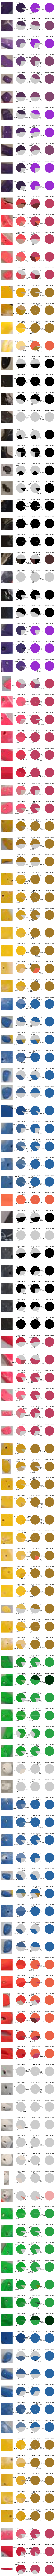

In [36]:
fig,ax = plt.subplots(len(hold_imgs), 4, figsize=(12,len(hold_imgs)*4))

for i,im in enumerate(hold_imgs):
    
    ax[i,0].imshow(im)
    
    results = kmean_results[i]
    
    center_colors_rgb = [cv2.cvtColor((c.reshape([1,1,3])), cv2.COLOR_HLS2RGB)[0][0] for c in results[0]]
    hex_colors = [f'#{RGB2HEX(c)}' for c in center_colors_rgb]
    center_colors_hls_str = [HLS_str(c) for c in results[0]]
    ax[i,1].pie(results[1], labels=center_colors_hls_str, colors=hex_colors)
    ax[i,1].set_title('CLUSTER MEANS')
    
    
    labels = [f'{r}\n {df_template_color.loc[df_template_color.name==r,"hls"].values[0]}' 
              for ir,r in enumerate(results[2])]
    template_hex = ['#' + df_template_color.loc[df_template_color.name==c,"hex"].values[0] for c in results[2]]
    ax[i,2].pie(results[1], labels=labels, colors=template_hex)
    ax[i,2].set_title('MATCHED COLORS')
    
    chosen_hex = ['#' + df_template_color.loc[df_template_color.name==results[3],"hex"].values[0]]
    ax[i,3].pie([1], colors=chosen_hex)
    ax[i,3].set_title('CHOSEN COLORS')

    ax[i,0].axis('off')
    ax[i,1].axis('off')
    ax[i,2].axis('off')
